In [1]:
from model import MyFasterRCNN
from data import BedsoreDataModule
from utils import batch2pil, draw_bbox, out2detfile
from matplotlib import pyplot as plt
import os
from PIL import Image
import numpy as np
import torch
from ensemble_boxes import *

/home/zrway/anaconda3/lib/python3.7/site-packages/scipy/special/orthogonal.py:81: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from numpy import (exp, inf, pi, sqrt, floor, sin, cos, around, int,
/home/zrway/anaconda3/lib/python3.7/site-packages/skimage/morphology/_skeletonize.py:241: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumP

In [2]:
dm = BedsoreDataModule(root='data', num_valid=100, batch_size=1, trans_prob=0.5)
ds = dm.test_dataloader().dataset

/home/zrway/anaconda3/lib/python3.7/site-packages/albumentations/pytorch/transforms.py:58: DeprecationWarning: ToTensor is deprecated and will be replaced by ToTensorV2 in albumentations 0.5.0
  "ToTensor is deprecated and will be replaced by ToTensorV2 " "in albumentations 0.5.0", DeprecationWarning


B05_00065
gt: tensor([5, 7])


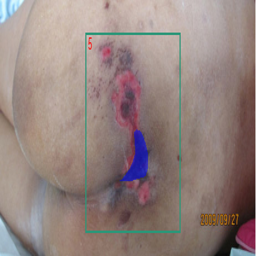

In [253]:
SZ = 256
idx = 97 # 22 25 32 49 93 95 97
image,target = ds[idx]
print(target['fname'])
print('gt:',target['labels'])
draw_bbox(image,target).resize((SZ,SZ))

/home/zrway/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


out labels:  tensor([6, 6, 5, 2, 2, 6, 7, 5, 5, 7, 7, 6, 5, 6])
out scores:  tensor([0.5885, 0.5132, 0.3213, 0.2439, 0.2282, 0.2217, 0.2035, 0.1977, 0.1476,
        0.1312, 0.1170, 0.0950, 0.0880, 0.0660])
tensor([[187.5542,  41.2537, 269.4808, 119.5855],
        [169.7896,  31.9784, 304.9370, 175.4805],
        [161.1199,  28.5033, 305.2145, 186.0914],
        [156.5460,   4.3177, 231.0371,  71.8732],
        [162.5564,  20.1203, 226.0306,  56.3605],
        [196.3922,  97.3007, 297.0076, 179.3067],
        [214.7776,  75.7563, 243.4100, 102.5415],
        [187.9688,  57.1045, 286.4793, 161.4547],
        [195.2956,  49.9863, 268.0689, 121.1503],
        [220.7543,  80.5268, 237.8833,  97.9686],
        [212.0498, 116.3498, 272.0436, 152.6557],
        [198.2754,  59.4440, 254.7903, 103.1982],
        [195.9984,  97.2669, 298.0038, 180.7724],
        [148.8264,   9.4862, 280.0191, 114.0334]], grad_fn=<StackBackward>)


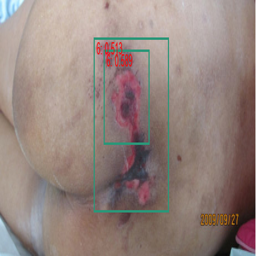

In [254]:
model = MyFasterRCNN.load_from_checkpoint('mlruns/3/f05e716e77b9480e986dd904487b5b3a/checkpoints/epoch=53.ckpt')
net = model.net
net.eval()
out = net([image],[target])[0]
print('out labels: ', out['labels'])
print('out scores: ', out['scores'].detach())
print(out['boxes'])
draw_bbox(image,out,th=0.5).resize((SZ,SZ))

0 1


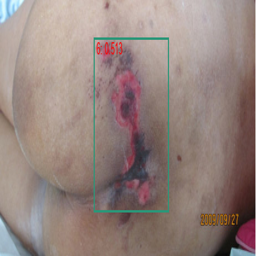

In [255]:
# 输入的是一个out，参数score_th=0.5，overlap_th>0.9

@torch.no_grad()
def same_class_remove(out, score_th=0.5, overlap_th=0.9):
    passing_scores_ind = torch.where(out["scores"] > score_th)[0]
    for i in range(1, 7):
        labels_ind = torch.where(out["labels"] == i)[0]
        if labels_ind.size(0) > 1:
            ind = set(passing_scores_ind.tolist()) & set(labels_ind.tolist())
            ind = list(ind)
            for i in ind:
                for j in ind[i + 1 :]:
                    print(i, j)
                    box_i = out['boxes'][i].detach()
                    box_j = out['boxes'][j].detach()
                    box_cat = out['boxes'][[i,j]]
                    ov_x1 = box_cat[:,0].max()
                    ov_y1 = box_cat[:,1].max()
                    ov_x2 = box_cat[:,2].min()
                    ov_y2 = box_cat[:,3].min()
                    if ov_x2>ov_x1 and ov_y2>ov_y1:
                        area_ov =  (ov_x2-ov_x1)*(ov_y2-ov_y1).item()
                        area_i = (box_i[2]-box_i[0])*(box_i[3]-box_i[1]).item()
                        area_j = (box_j[2]-box_j[0])*(box_j[3]-box_j[1]).item()

                        if area_i > area_j:
                            area_min = area_j
                            pending = j
                        else:
                            area_min = area_i
                            pending = i

                        ovmin = area_ov/area_min
                        if ovmin.item()>overlap_th:
                            out['scores'][pending] = 0
    return out

                        
                    
out = same_class_remove(out)
draw_bbox(image,out,th=0.5).resize((SZ,SZ))

out2 labels:  tensor([6, 6, 6])
out2 scores:  tensor([0.9938, 0.7332, 0.4472])
tensor([[ 415.7959,    0.0000, 1173.1010,  668.7584],
        [ 483.8917,  271.4320, 1025.7422,  627.6111],
        [ 501.2024,   16.8635, 1146.6649,  392.9622]], grad_fn=<StackBackward>)


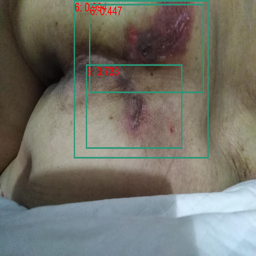

In [5]:
model2 = MyFasterRCNN.load_from_checkpoint('mlruns/3/bf9cd266df184592ac8cbc88e7820199/checkpoints/epoch=51.ckpt')
net2 = model2.net
net2.eval()
out2 = net2([image],[target])[0]
print('out2 labels: ', out2['labels'])
print('out2 scores: ', out2['scores'].detach())
print(out2['boxes'])
draw_bbox(image,out2,th=0.4).resize((SZ,SZ))

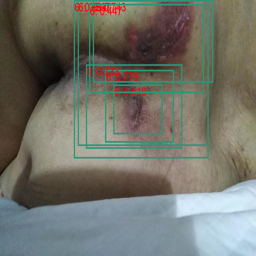

In [6]:
boxes_mix = torch.cat((out['boxes'],out2['boxes']),0)
labels_mix = torch.cat((out['labels'],out2['labels']),0)
scores_mix = torch.cat((out['scores'],out2['scores']),0)
masks_mix = torch.cat((out['masks'],out2['masks']),0)
out_mix = {'boxes':boxes_mix,'labels':labels_mix,'scores':scores_mix,'masks':masks_mix}
draw_bbox(image,out_mix,th=0.4).resize((SZ,SZ))

[[ 423.45299721    0.         1173.12397957  650.04908323]
 [ 533.78118038  274.31263804 1015.16615868  626.39657021]
 [ 514.66110706    6.33496111 1179.69697952  365.21152139]
 [ 637.01464176  356.06788158  914.41054344  566.66871071]
 [ 860.73597908  429.81953144 1043.01650047  622.0418644 ]
 [ 651.24137878  379.45286036 1058.69115829  625.19717216]] [0.76524395 0.61841351 0.59527749 0.51931792 0.22295472 0.15025508] [6. 6. 6. 6. 2. 6.]


/home/zrway/anaconda3/lib/python3.7/site-packages/numba/core/ir_utils.py:1525: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)


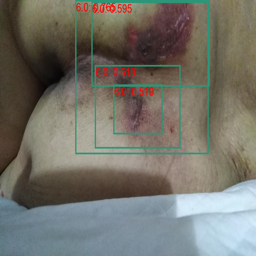

In [8]:
# 后处理
# norm boxes
out = out_mix


h = image.shape[1]
w = image.shape[2]
x1 = out['boxes'][:,0]/w
x2 = out['boxes'][:,2]/w
y1 = out['boxes'][:,1]/h
y2 = out['boxes'][:,3]/h
norm_boxes = torch.stack((x1,y1,x2,y2),1).tolist()

# 后处理
boxes_list = norm_boxes
scores_list = out['scores'].tolist()
labels_list = out['labels'].tolist()
weights = None
iou_thr = 0.5
skip_box_thr = 0.0001
sigma = 0.1
# boxes, scores, labels = nms([boxes_list], [scores_list], [labels_list], weights=weights, iou_thr=iou_thr)
# boxes, scores, labels = soft_nms([boxes_list], [scores_list], [labels_list], weights=weights, iou_thr=iou_thr, sigma=sigma, thresh=skip_box_thr)
non_maximum_weighted([boxes_list], [scores_list], [labels_list], weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
# boxes, scores, labels = weighted_boxes_fusion([boxes_list], [scores_list], [labels_list], weights=None, iou_thr=iou_thr, skip_box_thr=0.0001)

# denorm
x1 = boxes[:,0]*w
x2 = boxes[:,2]*w
y1 = boxes[:,1]*h
y2 = boxes[:,3]*h
dnorm_boxes = np.stack((x1,y1,x2,y2),1)
print(dnorm_boxes,scores,labels)
out['boxes'] = torch.from_numpy(dnorm_boxes)
out['scores'] = torch.from_numpy(scores)
out['labels'] = torch.from_numpy(labels)
draw_bbox(image,out,th=0.4,show_mask=False).resize((SZ,SZ))

### Batch Eval 计算分数

In [1]:
from model import MyFasterRCNN
from data import BedsoreDataModule
from utils import batch2pil, draw_bbox, out2detfile
from matplotlib import pyplot as plt
from tqdm import tqdm
import voc_eval
import os

detpath = 'temp/det_outs.txt'
imgsetfile = 'temp/evallist.txt'

In [3]:
dm = BedsoreDataModule(root='data', num_valid=100, batch_size=1,trans_prob=0.5)
ds = dm.val_dataloader().dataset
model = MyFasterRCNN.load_from_checkpoint('mlruns/0/40eb48da3c844db9afc77346b7d1d29f/checkpoints/epoch=18.ckpt')
net = model.net
net.eval()
pass

/home/zrway/anaconda3/lib/python3.7/site-packages/albumentations/pytorch/transforms.py:58: DeprecationWarning: ToTensor is deprecated and will be replaced by ToTensorV2 in albumentations 0.5.0
  "ToTensor is deprecated and will be replaced by ToTensorV2 " "in albumentations 0.5.0", DeprecationWarning


In [4]:
# 预测
outs = []
for image,target in tqdm(ds):
    out = net([image],[target])[0]
    outs += out2detfile(target,out)        

  0%|          | 0/100 [00:00<?, ?it/s]/home/zrway/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
100%|██████████| 100/100 [03:23<00:00,  2.03s/it]


In [5]:
# 将检测结果写入文件
os.remove(detpath)
for i in outs:
    with open(detpath,'a+') as f:
        f.write(i)

In [6]:
# 预测文件列表

os.remove(imgsetfile)
for _,target in ds:
    fname= target['fname']
    with open(imgsetfile,'a+') as f:
        f.write(fname +'\n')

In [7]:
voc_eval.voc_eval(detpath,
                  'data/VOCdevkit/VOC2007/Annotations/{}.xml',
                  imgsetfile,
                  '深部组织损伤',
                  ovthresh=0.3,
                  use_07_metric=True)

(array([0.09090909, 0.18181818, 0.27272727, 0.36363636, 0.45454545,
        0.54545455, 0.63636364, 0.72727273, 0.72727273, 0.72727273,
        0.72727273, 0.72727273, 0.72727273, 0.72727273, 0.72727273,
        0.72727273, 0.72727273]),
 array([1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 0.88888889, 0.8       ,
        0.72727273, 0.66666667, 0.61538462, 0.57142857, 0.53333333,
        0.5       , 0.47058824]),
 0.7272727272727274)

In [8]:
tissus_name = ['1期','2期','3期','4期','不可分期','深部组织损伤']
mAP = []
for i in tissus_name:
    ap = voc_eval.voc_eval(detpath,
                  'data/VOCdevkit/VOC2007/Annotations/{}.xml',
                  imgsetfile,
                  i,
                  ovthresh=0.3,
                  use_07_metric=True)[-1]
    print(ap)
    mAP.append(ap)
sum(mAP)/len(mAP)

0.0
0.4418081918081918
0.5099206349206349
0.7665188470066518
0.5867965367965369
0.7272727272727274


0.5053861563007905